In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import scipy as sp
import scipy.stats as stats
%matplotlib inline

In [2]:
# pricing parameters

# economics
K = 100.0
T = 1.

# market data
Vol = 0.2
R = 0.05
S0 = 110.0

In [3]:
# black scholes analytic solutions

def d1(s, k, r, vol, t):
    return (sp.log(s/k)+(r+(0.5*vol*vol))*t)/(vol*sp.sqrt(t))
def d2(s, k, r, vol, t):
    return (sp.log(s/k)+(r-(0.5*vol*vol))*t)/(vol*sp.sqrt(t))
def bs_call(s, k, r, vol, t):
    return s*stats.norm.cdf(d1(s, k, r, vol, t)) - k*sp.exp(-1.*r*t)*stats.norm.cdf(d2(s, k, r, vol, t))
def bs_put(s, k, r, vol, t):
    return -1.*s*stats.norm.cdf(-1.*d1(s, k, r, vol, t)) + k*sp.exp(-1.*r*t)*stats.norm.cdf(-1.*d2(s, k, r, vol, t))
def bs_digital_call(s, k, r, vol, t):
    return sp.exp(-1.*r*t)*stats.norm.cdf(d2(s, k, r, vol, t))
def bs_digital_put(s, k, r, vol, t):
    return sp.exp(-1.*r*t)*(1.-stats.norm.cdf(d2(s, k, r, vol, t)))
def zcb(r ,t):
    return sp.exp(-1.*r*t)

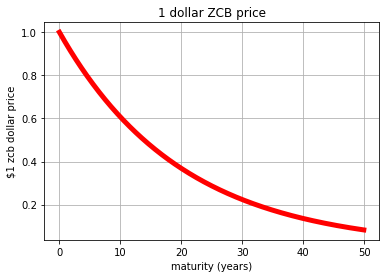

In [4]:
maturities = np.arange(0., 50., 0.1)
zcb_prices = zcb(R, maturities)
line, = plt.plot(maturities, zcb_prices, 'r-')
#plt.xkcd(True)
plt.setp(line, color='r', linewidth=5.0)
plt.xlabel('maturity (years)')
plt.ylabel('$1 zcb dollar price')
plt.title('1 dollar ZCB price')
plt.grid(True)
plt.show()

In [5]:
# bs call price test

bs_option_price = bs_call(S0, K, R, Vol, T)
bs_option_price

17.662953740590439

In [6]:
# monte carlo (simple)

def create_random_generator():
    return lambda num_of_paths : np.random.normal(0.0, 1.0, num_of_paths)

def create_vanilla_option(payoff, expiry):
    return (payoff, expiry)

def create_call_payoff(k):
    return lambda s : np.maximum(s-k, 0.)

def create_put_payoff(k):
    return lambda s : np.maximum(k-s, 0.)

def create_call_digital_payoff(k):
    return lambda s : 1. * (s > k)

def create_put_digital_payoff(k):
    return lambda s : 1. * (s < k)

def random_stock_paths(s0, r, t, vol, rnd_generator, num_of_paths):
    return s0*sp.exp(r*t-0.5*vol*vol*t+vol*sp.sqrt(t)*rnd_generator(num_of_paths))

def monte_carlo_price(option, rnd_generator, s0, r, vol, num_of_paths):
    expiry = option[1]
    payoff = option[0]
    payoffs = payoff(random_stock_paths(s0, r, expiry, vol, rnd_generator, num_of_paths))
    std_error = np.std(sp.exp(-1.*r*expiry)*payoffs)/np.sqrt(num_of_paths)
    price = sp.exp(-1.*r*expiry)*np.mean(payoffs)
    return price, std_error

def mc_price_option(s0, r, expiry, vol, k, num_of_paths):
    option = create_vanilla_option(create_call_payoff(k), expiry)
    return monte_carlo_price(option, create_random_generator(), s0, r, vol, num_of_paths)


In [7]:
# monte carlo 2 (path dependent exotic pricer)

class asian_product:
    def __init__(self, payoff, observation_times, expiry):
        self.payoff = payoff
        self.observation_times = observation_times
        self.expiry = expiry
    def get_observation_times(self):
        return self.observation_times
    def get_cashflow_times(self):
        return np.array([self.expiry])
    def generate_cashflows(self, spots):
        return np.array([np.sum(self.payoff.calc(spots))/12.])

class vanilla_product:
    def __init__(self, payoff, expiry):
        self.payoff = payoff
        self.expiry = expiry
    def get_observation_times(self):
        return np.array([self.expiry])
    def get_cashflow_times(self):
        return np.array([self.expiry])
    def generate_cashflows(self, spots):
        return self.payoff.calc(spots)
        
class call_payoff:
    def __init__(self, k):
        self.k = k
    def calc(self, spots):
        return np.maximum(spots-self.k, 0.)
    
#def create_random_generator(dimensions):
#    return lambda : np.random.normal(0.0, 1.0, dimensions)
    
def bs_monte_carlo_price(product, s0, r, vol, number_of_paths):
    # pre-calculate discount factors for cashflows
    dfs = [zcb(r, ct) for ct in product.get_cashflow_times()]
    # pre-calculate drifts/std devs between observation times
    drift, stddevs = pre_calc_path_params(product.get_observation_times(), r, vol)
    # run simulation
    price = 0.
    for i in range(number_of_paths):
        spots = generate_path(sp.log(s0), drift, stddevs)
        cashflows = product.generate_cashflows(spots)
        discounted_cashflows = [df*cf for df, cf in zip(dfs, cashflows)]
        fv = np.sum(discounted_cashflows)
        price += fv
    price /= number_of_paths
    return price

def pre_calc_path_params(observation_times, r, vol):
    variance = vol*vol*observation_times[0]
    drifts = np.zeros(len(observation_times))
    stddevs = np.zeros(len(observation_times))
    drifts[0] = r*observation_times[0] - 0.5*variance
    stddevs[0] = sp.sqrt(variance)
    for i in range(1, len(observation_times)):
        time = observation_times[i]-observation_times[i-1]
        variance = vol*vol*time
        drifts[i] = r*time - 0.5*variance
        stddevs[i] = sp.sqrt(variance)
    return drifts, stddevs

def generate_path(log_spot, drift, stddevs):
    spots = np.zeros(len(drift))
    randoms = np.random.normal(0.0, 1.0, len(drift))
    current_log_spot = log_spot
    for i in range(len(drift)):
        current_log_spot += drift[i]
        current_log_spot += stddevs[i]*randoms[i]
        spots[i] = sp.exp(current_log_spot)
    return spots
    
asian_obs_times = [i/12. for i in range(1,13)]


bs_monte_carlo_price(vanilla_product(call_payoff(K), T), S0, R, Vol, 10000)
bs_monte_carlo_price(asian_product(call_payoff(K), asian_obs_times, T), S0, R, Vol, 10000)

14.07278089244935

In [8]:
mc_price_option(S0, R, T, Vol, K, 10000)

(17.346431790548806, 0.18782952862569793)

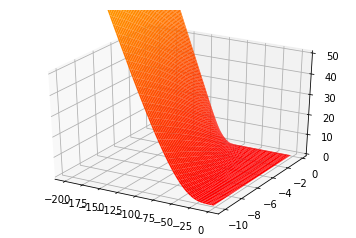

In [9]:
# 3d plot of BS call price over time and spot

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
ss = np.arange(1., 201., 1.)
tt = np.arange(10.1, 0.1, -0.1)
ss, tt = np.meshgrid(ss, tt)
bs_price = bs_call(ss, K, R, Vol, tt)
payoff_fn = create_call_payoff(K)
#mc_price = monte_carlo_price(ss, r, tt, vol, k, payoff_fn, 1000)

# Plot the surface.
surf = ax.plot_surface(-ss, -tt, bs_price, cmap=cm.autumn,
                       linewidth=0, antialiased=True)
#surf2 = ax.plot_surface(-ss, -tt, mc_price, cmap=cm.coolwarm,
#                      linewidth=0, antialiased=True)

# Customize the z axis.
ax.set_zlim(0.0, 50.0)

plt.show()

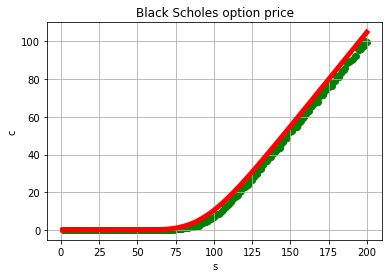

In [10]:
spots = np.arange(1., 201., 1.)
bs_price = bs_call(spots, K, R, Vol, T)
#mc_price = [mc_price_option(spot, R, T, Vol, K, 10000)[0] for spot in spots]
#mc_price = [bs_monte_carlo_price(vanilla_product(call_payoff(K), T), spot, R, Vol, 1000) for spot in spots]
mc_price = [bs_monte_carlo_price(asian_product(call_payoff(K), asian_obs_times, T), spot, R, Vol, 1000) for spot in spots]

plt.scatter(spots, mc_price, color=['green'])
line, = plt.plot(spots, bs_price, 'r-')
plt.setp(line, color='r', linewidth=5.0)

plt.xlabel('s')
plt.ylabel('c')
plt.title('Black Scholes option price')
plt.grid(True)
plt.show()

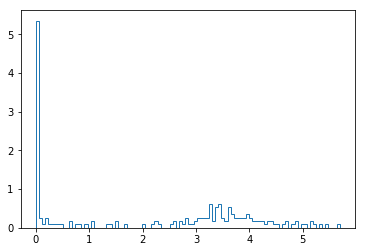

In [11]:
# BS vs MC price error as a histogram

price_error = bs_price-mc_price
x=plt.hist(price_error, bins=100,normed=1,histtype='step')

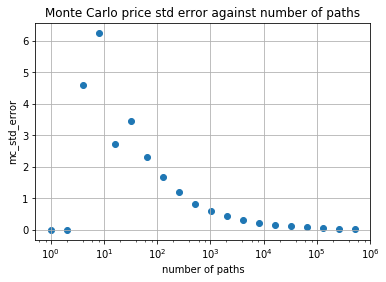

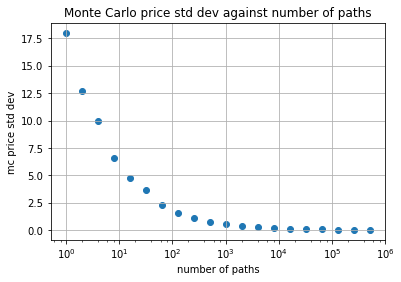

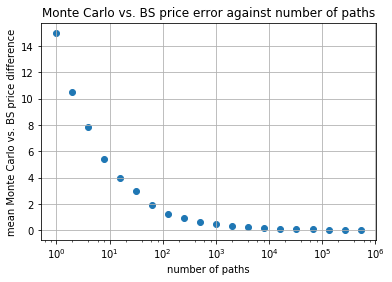

In [12]:
# Monte Carlo price statistics
numbers_of_paths = [2**x for x in np.arange(20)]

mc_std_error = [mc_price_option(S0, R, T, Vol, K, paths)[1] for paths in numbers_of_paths]

# show standard dev of MC prices across multiple trials decreasing with number of trials
number_of_trials = 100

mc_prices = [[mc_price_option(S0, R, T, Vol, K, number_of_paths)[0] for p in np.arange(number_of_trials)] \
             for number_of_paths in numbers_of_paths]

mc_price_std_dev = [np.std(prices) for prices in mc_prices]
mc_price_vs_bs = [np.mean([np.abs(p-bs_option_price) for p in prices]) for prices in mc_prices]

plt.subplot()
plt.scatter(numbers_of_paths, mc_std_error)
plt.xlabel('number of paths')
plt.ylabel('mc_std_error')
plt.title('Monte Carlo price std error against number of paths')
plt.grid(True)
plt.xscale('log')
plt.show()

plt.subplot()
plt.scatter(numbers_of_paths, mc_price_std_dev)
plt.xlabel('number of paths')
plt.ylabel('mc price std dev')
plt.title('Monte Carlo price std dev against number of paths')
plt.grid(True)
plt.xscale('log')
plt.show()

plt.subplot()
plt.scatter(numbers_of_paths, mc_price_vs_bs)
plt.xlabel('number of paths')
plt.ylabel('mean Monte Carlo vs. BS price difference')
plt.title('Monte Carlo vs. BS price error against number of paths')
plt.grid(True)
plt.xscale('log')
plt.show()
plt.show()